# IML - Projet Carotte 4.0

**Auteurs :** Nicolas Blin, Quentin Kaci et Théo Lepage.

## Sommaire

1. [Introduction et présentation du problème](#section-1)
2. [Solutions envisagées](#section-2)
3. [Protocole expérimental](#section-3)
    - 3.1 [Chargement et préparation des données](#section-31)
    - 3.2 [Étape de pré-traitement](#section-32)
    - 3.3 [Création et entraînement du modèle](#section-33)
    - 3.4 [Étape de post-traitement](#section-34)
    - 3.5 [Critères d'évaluation des résultats](#section-35)
4. [Présentation des résultats obtenus](#section-4)
    - 4.1 [Sans pré-traitement sans post-traitement](#section-41)
    - 4.2 [Sans pré-traitement avec post-traitement](#section-42)
    - 4.3 [Avec pré-traitement sans post-traitement](#section-43)
    - 4.4 [Avec pré-traitement et post-traitement](#section-44)
    - 4.5 [En faisant varier le pourcentage de données d'entraînement](#section-45)
5. [Conclusion et analyse des résultats](#section-5)
6. [Travail individuel](#section-6)

<a id="section-1"></a>

## 1. Introduction et présentation du problème

Nous sommes trois ingénieurs fraîchement diplomés de l'EPITA. Notre équipe, la *Holoteam*, a été recrutée par la start-up Carotte 4.0.  

Leur objectif ? Être capable de **suivre l'évolution des ressources agricoles** en milieu urbain et rural. Pour ce faire, ils nous fournissent des **images hyperspectrales** de deux zones aux USA prises depuis le ciel.  

Notre mission ? Prouver que les **techniques de machine-learning** sont capables d'apprendre à partir de ces images et de **prédir** à quelle ressource agricole un pixel correspond. Une fois entraînés, nos algorithmes génériques pourront être appliqués à de nouvelles images hyperspectrales et ainsi conclure sur l'occupation des sols.

<a id="section-2"></a>

## 2. Solutions envisagées

### 2.1 Premières solutions envisagées

Afin de classifier les données, la *Holoteam* s'est en premier lieu tournée vers une solution simple : explorer les **hyperparamètres** des principaux **classifieurs** de la bibliothèque **scikit-learn** :
1. SVM
2. Random Forest
3. K-Nearest-Neighbors

Avec 85% de précision, nous avons jugé les résultats insuffisants. Les étapes de **pre et post processing** n'étaient, à priori, pas assez poussées car limitées à une **PCA** et une **normalisation**.

### 2.2 Solution finale

L'équipe s'est alors tournée vers la **littérature scientifique**. L'article suivant a été retenu : [Hyperspectral image classification with SVM and guided filter](https://www.researchgate.net/publication/331610000_Hyperspectral_image_classification_with_SVM_and_guided_filter) de Yanhui Guo, Xijie Yin, Xuechen Zhao, Dongxin Yang and Yu Bai.
Grâce à un pre/post-processing plus avancé via **filtre-guidés**, les résultats furent alors considérablement améliorés (99% de précision).

Cette solution est bien plus efficace en terme de coût énergétique. En effet, l'exploration d'un grand nombre d'hyperparamètres pour plusieurs classifieurs est un processus long et très énergivore. La complexité de la pipeline a cependant augmenté. Elle impose l'application systématique d'une PCA et d'une passe de lissage en pré et post traitement. De plus, cette pipeline impose la prédiction sur une image (pour exploiter les informations des pixels voisins) et non plus sur des pixels isolés.

### 2.3 Description détaillée de la pipeline finale

Comme indiqué plus haut, un pre-processing léger appliqué sur les informations spectrales ne suffit pas pour classifier efficacement les images, même en explorant leurs nombreux hyperparamètres.

On remarque qu'au sein d'un espace agricole (un champ de maïs par exemple), un pixel a une probabilité très élevée d'être à côté d'autres pixels de maïs. Cependant, tous ces pixels de maïs ne possèdent pas exactement les mêmes informations spectrales ce qui rend la tâche de classification plus complexe.
L'idée est donc de venir **lisser** l'image en ajoutant les informations spectrales des pixels voisins. En procédant ainsi, tous les pixels du champ de maïs obtiennent des valeurs spectrales bien plus proche ce qui facilite la tâche du classifieur lors de l'apprentissage.
Le même procédé est appliqué de nouveau en post-processing. De la même manière, si un pixel au sein d'un champ de maïs n'a pas été prédit comme maïs, le résultat est lissé et la prédiction modifiée.

Pour lisser une image, il est nécessaire d'utiliser un **noyau**. C'est lui qui définit la manière d'utiliser les pixels voisins pour choisir la nouvelle valeur du pixel courant.
Dans notre cas, le noyau est construit à partir de l'image d'origine. Une **PCA** est en premier lieu appliquée sur l'image. Cette opération a pour but de réduire la dimension de l'image tout en conservant **le maximum de variance**. C'est cette image (généralement réduite à 3 dimensions) qui est utilisée lors du pré et post traitement.

Lors de la classification, un **SVM** traditionnel est utilisé. Afin d'améliorer les résultats, comme lors du premier jet de solution, un **GridSearch** est utilisé. GridSearch est un outil de scikit permettant d'explorer toutes les **combinaisons d'hyperparamètres** d'un classifieur donné et de conserver la meilleure.

![pipeline](https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13638-019-1346-z/MediaObjects/13638_2019_1346_Fig1_HTML.png)
*Pipeline utilisée pour classifier une image hyperspectrale*

<a id="section-3"></a>

## 3. Protocole expérimental

In [ ]:
SEED = 1010

TEST_RATIO = 0.7

LABELS1 = ['Background',
           'Alfalfa',
           'Corn notill',
           'Corn mintill',
           'Corn',
           'Grass pasture',
           'Grass trees',
           'Grass pasture mowed',
           'Hay windrowed',
           'Oats',
           'Soybean notill',
           'Soybean mintill',
           'Soybean clean',
           'Wheat',
           'Woods',
           'Buildings Grass Trees Drives',
           'Stone Steel Towers']

LABELS2 = ['Background',
           'Brocoli green weeds 1',
           'Brocoli green weeds 2',
           'Fallow',
           'Fallow rough plow',
           'Fallow smooth',
           'Stubble',
           'Celerey',
           'Grapes untrained',
           'Soil vinyard develop',
           'Corn senesced green weeds',
           'Lettuce romaine 4wk',
           'Lettuce romaine 5wk',
           'Lettuce romaine 6wk',
           'Lettuce romaine 7wk',
           'Vinyard untrained',
           'Vinyard vertical trellis']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

<a id="section-31"></a>

### 3.1 Chargement et préparation des données

Les données sont ici chargées et **normalisées** par la valeur maximum de toute l'image hyperspectrale. En machine-learning, cela représente une bonne pratique de ramener ses données entre 0 et 1.

In [ ]:
X1 = np.load('indianapines.npy')
X1 = X1 / X1.max()
y1 = np.load('indianapines_gt.npy')

In [ ]:
X2 = np.load('salinas.npy')
X2 = X2 / X2.max()
y2 = np.load('salinas_gt.npy')

In [ ]:
def hsi_to_rgb_pimped(hsi):
    # Create a RGB image with enhanced contrast for visualization purposes 
    rgb_bands = np.array([30, 15, 2])
    rgb = hsi[:, :, rgb_bands]

    pmin, pmax = np.percentile(rgb, (1, 99), axis=(0, 1))
    rgb_pimped = rgb.copy()
    for i in range(pmin.size):
        rgb_pimped[:, :, i] = (rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
    rgb_pimped[rgb_pimped < 0] = 0
    rgb_pimped[rgb_pimped > 1] = 1

    return rgb_pimped

In [ ]:
from matplotlib.lines import Line2D
import matplotlib

def gt_add_legend(labels):
    # Create custom legend for each label
    cmap = matplotlib.cm.get_cmap('viridis')
    legend = []
    for i, label in enumerate(labels):
        color = cmap(i / len(labels))
        legend.append(Line2D([0], [0], color='w', label=label, marker='o',
                             markerfacecolor=color, markersize=15))
    plt.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_hsi_and_gt(hsi, gt, labels):
    rgb = hsi_to_rgb_pimped(hsi)

    # Prevent having a gap between hsi and gt of image 2
    w = 10 if hsi.shape[1] == 145 else 6

    plt.figure(figsize=(w, 5))
    plt.subplot(121)
    plt.title('RGB version of HSI')
    plt.imshow(rgb)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.title('Ground truth of HSI')
    plt.imshow(gt)
    plt.xticks([])
    plt.yticks([])

    gt_add_legend(labels)
    plt.show()

Indian Pines HSI has 145 rows, 145 columns and 200 bands.



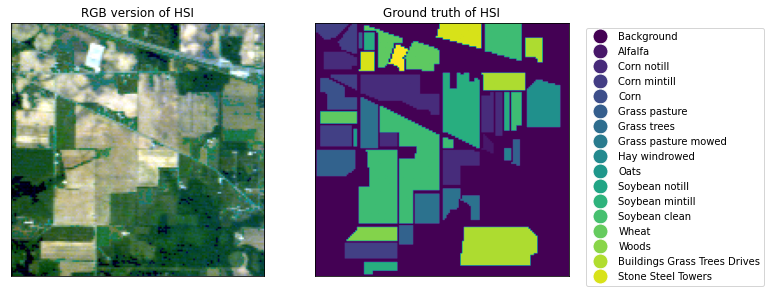

In [ ]:
row, col, dim = X1.shape
print('Indian Pines HSI has %d rows, %d columns and %d bands.\n'%(row, col, dim))

plot_hsi_and_gt(X1, y1, LABELS1)

Salinas HSI has 512 rows, 217 columns and 204 bands.



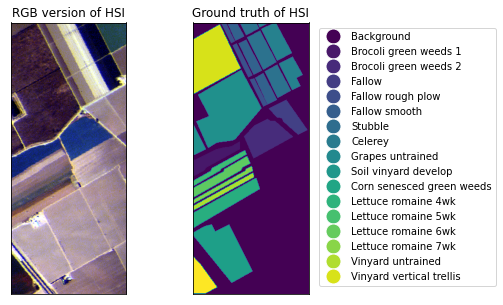

In [ ]:
row, col, dim = X2.shape
print('Salinas HSI has %d rows, %d columns and %d bands.\n'%(row, col, dim))

plot_hsi_and_gt(X2, y2, LABELS2)

<a id="section-32"></a>

### 3.2 Étape de pré-traitement

#### Implémentations de [Guided Image Filtering](http://kaiminghe.com/publications/pami12guidedfilter.pdf) de Kaiming He, Jian Sun et Xiaoou Tang

L'algorithme du filtre guidé se base sur une *guidance image* pour calculer l'image de sortie. Cette dernière peut être l'image d'entrée ou une image différente. Cette technique fonctionne à la façon du *filtre bilateral* tout en fournissant de meilleurs résultats près des bords au sein de l'image. De plus, sa propriété de **préservation des bords** le rend très intéressant dans notre cas car cela permet de garder la structure globale (la séparation des différentes plantations) en s'appuyant sur l'image originale. Enfin, cet algorithme a l'avantage d'être relativement rapide : $O(N)$ avec $N$ le nombre de pixels.

L'algorithme repose sur l'hypothèse que la sortie $q$ est une transformation linéaire de la *guidance image* $I$ dans une région $\omega_{k}$ (carrée et de rayon $r$) centrée autour du pixel $k$.

$$
q_{i}=a_{k} I_{i}+b_{k}, \forall i \in \omega_{k}
$$

Les équations des coéfficients $a_k$ et $b_k$ sont donnés ci-dessous.

$$
a_{k}=\frac{\frac{1}{|\omega|} \sum_{i \in \omega_{k}} I_{i} p_{i}-\mu_{k} \bar{p}_{k}}{\sigma_{k}^{2}+\epsilon}
$$

$$
b_{k}=\bar{p}_{k}-a_{k} \mu_{k}
$$

Avec :
- $p$ l'image d'entrée,
- $\mu_{k}$ et $\sigma_{k}^{2}$ la moyenne et la variance de $I$ dans $\omega_{k}$,
- $|\omega|$ le nombre de pixels dans $\omega_{k}$,
- $\bar{p}_{k}=\frac{1}{|\omega|} \sum_{i \in \omega_{k}} p_{i}$ la moyenne de $p$ dans $\omega_{k}$.

---

Notre implémentation `GuidedFilterColorSlow` se base sur l'algorithme 1 de l'article et du code MATLAB mis à disposition par ses auteurs. Pour réduire le temps de calcul nous nous reposons sur la méthode `cv2.ximgproc.guidedFilter` de la bibliothèque OpenCV (disponible uniquement dans le package `opencv-contrib-python`).

Dans notre cas, nous utilisons des *guidance images* $I$ en couleur (3 canaux) car cela donnait de meilleurs résultats que celles en niveaux de gris (1 canal). Les résultats obtenus avec plus de canaux (5, 7 et 10) ne justifiaient pas de gérer ce cas dans notre implémentation. Même si OpenCV le propose nous avons préféré ne pas nous appuyer sur une fonctionnalité que nous n'avons pas implémenté.

In [ ]:
class GuidedFilterColorFast:
    """
    Fast implementation (with OpenCV) of Guided Image Filtering
    for 3D/RGB guidance images.
    """

    def __init__(self, I, r, eps):
        """
        Constructor of GuidedFilterColorFast class.

        @param I   Guidance image in 3D (RGB).
        @param r   Filter radius.
        @param eps Regularization parameter.
        """

        self.I = I
        self.r = r
        self.eps = eps

    def filter(self, p):
        """
        Filter input image with Guided Image Filtering algorithm.

        @param p Image (in 2D) to filter .

        @return Input image filtered with guidance image I.
        """

        return cv2.ximgproc.guidedFilter(self.I.astype('float32'),
                                         p.astype('float32'),
                                         self.r,
                                         self.eps)

In [ ]:
class GuidedFilterColorSlow:
    """
    Slow but intuitive implementation of Guided Image Filtering
    for 3D/RGB guidance images.
    """

    def __init__(self, I, r, eps):
        """
        Constructor of GuidedFilterColorSlow class.

        @param I   Guidance image in 3D (RGB).
        @param r   Filter radius.
        @param eps Regularization parameter.
        """

        self.I = I
        self.r = r
        self.eps = eps

    def __f_mean(self, image, r, normalize=True):
        """
        Box filtering using cumulative sum.
        dst(x, y) = sum(sum(src(x-r:x+r,y-r:y+r)))
        
        Python implementation of MATLAB code for boxfilter,
        provided by the authors at http://kaiminghe.com/eccv10/.

        @param image     Input image (2D or 3D).
        @param r         Filter radius.
        @param normalize Whether to normalize output image.

        @return Box filtered input image.
        """

        rows, cols = image.shape[:2]
        res = np.zeros_like(image)

        tile = [1] * image.ndim
        tile[0] = r

        cum = np.cumsum(image, 0)
        res[0:r+1, :] = cum[r:2*r+1, :]
        res[r+1:rows-r, :] = cum[2*r+1:rows, :] - cum[0:rows-2*r-1, :]
        res[rows-r:rows, :] = np.tile(cum[rows-1:rows, :], tile) - cum[rows-2*r-1:rows-r-1, :]

        tile = [1] * image.ndim
        tile[1] = r

        cum = np.cumsum(res, 1)
        res[:, 0:r+1] = cum[:, r:2*r+1]
        res[:, r+1:cols-r] = cum[:, 2*r+1 : cols] - cum[:, 0 : cols-2*r-1]
        res[:, cols-r: cols] = np.tile(cum[:, cols-1:cols], tile) - cum[:, cols-2*r-1 : cols-r-1]

        # Normalize
        if normalize:
            N = self.__f_mean(np.ones_like(image), r, normalize=False)
            res = res / N

        return res

    def filter(self, p):
        """
        Filter input image with Guided Image Filtering algorithm.

        @param p Image (in 2D) to filter .

        @return Input image filtered with guidance image I.
        """

        # Step 1: Compute mean_I, mean_p, corr_I and corr_Ip

        mean_I_r = self.__f_mean(self.I[:, :, 0], self.r)
        mean_I_g = self.__f_mean(self.I[:, :, 1], self.r)
        mean_I_b = self.__f_mean(self.I[:, :, 2], self.r)

        mean_p = self.__f_mean(p, self.r)

        corr_I_rr = self.__f_mean(self.I[:, :, 0] * self.I[:, :, 0], self.r)
        corr_I_rg = self.__f_mean(self.I[:, :, 0] * self.I[:, :, 1], self.r)
        corr_I_rb = self.__f_mean(self.I[:, :, 0] * self.I[:, :, 2], self.r)
        corr_I_gg = self.__f_mean(self.I[:, :, 1] * self.I[:, :, 1], self.r)
        corr_I_gb = self.__f_mean(self.I[:, :, 1] * self.I[:, :, 2], self.r)
        corr_I_bb = self.__f_mean(self.I[:, :, 2] * self.I[:, :, 2], self.r)

        corr_Ip_r = self.__f_mean(self.I[:, :, 0] * p, self.r)
        corr_Ip_g = self.__f_mean(self.I[:, :, 1] * p, self.r)
        corr_Ip_b = self.__f_mean(self.I[:, :, 2] * p, self.r)

        # Step 2: Compute var_I and cov_Ip

        # Determine covariance matrix of I:
        #  | rr rg rb |
        #  | rg gg gb |
        #  | rb gb bb |
        
        var_I_rr = corr_I_rr - mean_I_r * mean_I_r
        var_I_rg = corr_I_rg - mean_I_r * mean_I_g
        var_I_rb = corr_I_rb - mean_I_r * mean_I_b
        var_I_gg = corr_I_gg - mean_I_g * mean_I_g
        var_I_gb = corr_I_gb - mean_I_g * mean_I_b
        var_I_bb = corr_I_bb - mean_I_b * mean_I_b

        var_Ip_r = corr_Ip_r - mean_I_r * mean_p
        var_Ip_g = corr_Ip_g - mean_I_g * mean_p
        var_Ip_b = corr_Ip_b - mean_I_b * mean_p

        # Step 3: Compute a and b

        a = np.zeros_like(self.I)
        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                cov_I = [[var_I_rr[i, j], var_I_rg[i, j], var_I_rb[i, j]],
                         [var_I_rg[i, j], var_I_gg[i, j], var_I_gb[i, j]],
                         [var_I_rb[i, j], var_I_gb[i, j], var_I_bb[i, j]]]

                cov_Ip = [var_Ip_r[i, j], var_Ip_g[i, j], var_Ip_b[i, j]]
                
                # Solve a(cov_I + eps) = cov_Ip to find a
                lhs = np.array(cov_I) + self.eps * np.eye(3)
                rhs = np.array(cov_Ip)
                a[i, j, :] = np.linalg.solve(lhs, rhs)

        b = mean_p
        b -= a[:, :, 0] * mean_I_r
        b -= a[:, :, 1] * mean_I_g
        b -= a[:, :, 2] * mean_I_b

        # Step 4: Compute mean_a and mean_b

        mean_a = self.__f_mean(a, self.r)
        mean_b = self.__f_mean(b, self.r)

        # Step 5: Compute q

        q = np.sum(mean_a * self.I, axis=2) + mean_b
        return q

#### Utilisation de Guided Image Filtering sur nos données

In [ ]:
class HSIProcessing:
    """
    Handle all pre/post processing steps used for our classification pipeline.
    """

    def __init__(self, hsi, r=3, eps=0.001, implem='fast'):
        """
        Constructor of HSIProcessing cass.

        @param hsi     Hyperspectral image to preprocess.
        @param r       Filter radius for Guided Image Filtering.
        @param eps     Regularization parameter for Guided Image Filtering.
        @param implem  Type of GF implementation to use (`fast` or `slow`).
        """ 

        assert hsi.ndim == 3

        I = self.compute_I(hsi)

        if implem == 'fast':
            self.implem = GuidedFilterColorFast(I, r, eps)
        elif implem == 'slow':
            self.implem = GuidedFilterColorSlow(I, r, eps)
        else:
            raise Exception('HSIProcessing: implem must be either `fast` \
                            or `slow`.')

    def compute_I(self, hsi):
        """
        Compute a 3D guidance image for Guided Image Filtering algorithm.

        @param hsi Hyperspectral image used to create the guidance image.
        
        @return A 3D guidance image of the input image.
        """

        rows, cols, dim = hsi.shape
        n_components = 3

        pca = PCA(n_components)
        I = pca.fit_transform(hsi.reshape((-1, dim)))
        I = I.reshape((rows, cols, n_components))
        return I

    def apply(self, hsi, verbose=True):
        """
        Apply Guided Image Filtering on each band/channel of input image.

        @param hsi Hyperspectral image to filter.
        
        @return Hyperspectral image filtered with GF on each band.
        """

        res = np.zeros_like(hsi)
        dim = hsi.shape[2]

        start = time.time()
        for i in range(dim):
            res[:, :, i] = self.implem.filter(hsi[:, :, i])
            if verbose:
              print('\rHSIProcessing: applied filtering on %d/%d bands.'
                  % (i+1, dim), end='')
        end = time.time()

        if verbose:
          print()
          print('HSIProcessing: elapsed time %fs.' % (end - start))
        return res

HSIProcessing: applied filtering on 200/200 bands.
HSIProcessing: elapsed time 0.307000s.


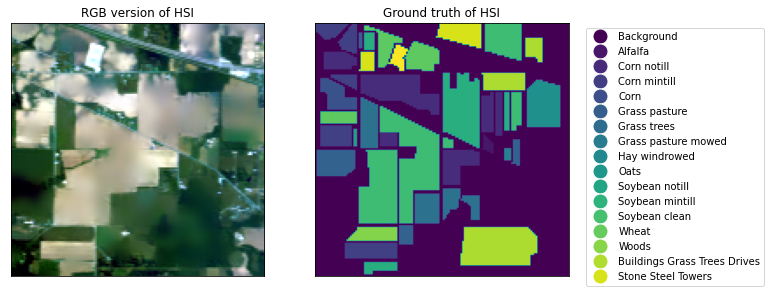

In [ ]:
gf1 = HSIProcessing(X1, r=3)
X1_f = gf1.apply(X1)

plot_hsi_and_gt(X1_f, y1, LABELS1)

HSIProcessing: applied filtering on 204/204 bands.
HSIProcessing: elapsed time 1.772001s.


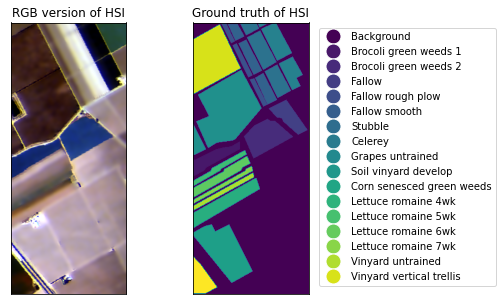

In [ ]:
gf2 = HSIProcessing(X2, r=3)
X2_f = gf2.apply(X2)

plot_hsi_and_gt(X2_f, y2, LABELS2)

<a id="section-33"></a>

### 3.3 Création et entraînement du modèle

#### 3.3.1 Séparation des train, validation et test set

#### Training set et test set

Dans un premier temps la *Holoteam* a dû faire un choix pour séparer en deux les données. Afin de mesurer l'efficacité d'un classifieur, il est nécessaire d'avoir un **training set** et un **test set**. Le training set est là pour permettre au classifieur de s'entrainer, le test set est lui utilisé pour mesurer la précision de ses prédictions. Il est important d'avoir un test set que le classifieur n'a jamais vu pour mesurer sa capacité à prédire sur des données jamais vu.
Idéalement, les deux sets sont composés de plusieurs images, cependant nous n'avons ici qu'une seule image par ensemble de catégories.

Pour séparer les données, deux solutions s'offrent à nous :

1. Séparer l'image en deux. Cette méthode présente le risque de manquer certaines catégories dans un des deux sets.
2. Séparer les données en deux au sein de chaque catégorie. Cela nous garantit que chaque catégorie soit présente et en même proportions dans les deux sets.

Cette dernière méthode présente le risque d'inclure dans le training set des pixels voisins et donc présentant de fortes similitudes ce qui limite la capacité de **généralisation** du classifieur. En effet, le classifieur risque d'apprendre grâce aux informations de connexité et non via les caractéristiques propres à chaque pixel.
Pour pallier ce problème, la *Holoteam* prend, d'une part, très peu de pixels dans le train set et, d'autre part, des pixels répartis aléatoirement dans l'image. Le classfieur évite ainsi d'apprendre par coeur l'image.

#### Training et validation sets

Le training set est lui-même séparé en deux au moment de l'entrainement générant ainsi un validation set. L'objectif est d'éviter le **surapprentissage** du training set en vérifiant l'écart de précision entre les deux sets. Si il devient trop grand, le classifieur a surappris et a perdu sa capacité de généralisation. Scikit-learn gère automatiquement cette séparation au niveau des classifieurs lorsqu'elle est nécessaire.

In [ ]:
def get_train_test_sets(X, y, test_ratio=TEST_RATIO):
    X = X.reshape((-1, X.shape[2]))
    y = y.flatten()

    indices = np.arange(X.shape[0])
    X_train, X_test, y_train, y_test, _, test_idx = train_test_split(X, y, indices,
                                                                     test_size=test_ratio,
                                                                     random_state=SEED,
                                                                     stratify=y)

    # Discard class 0 used for background
    test_idx = test_idx[y_test != 0]
    X_train = X_train[y_train != 0]
    y_train = y_train[y_train != 0]
    X_test = X_test[y_test != 0]
    y_test = y_test[y_test != 0]

    return X_train, X_test, y_train, y_test, test_idx

In [ ]:
X1_train, X1_test, y1_train, y1_test, test1_idx = get_train_test_sets(X1_f, y1)
X2_train, X2_test, y2_train, y2_test, test2_idx = get_train_test_sets(X2_f, y2)

In [ ]:
pipeline = Pipeline([
    ("pca", PCA()),
    ("svc", SVC(kernel='rbf', probability=True, random_state=SEED))
])

grid_params = {
    'pca__n_components': (range(60, 100, 1)),
    'svc__C': (range(660, 700, 1))
}

In [ ]:
gs1 = GridSearchCV(pipeline, grid_params, n_jobs=-1, verbose=4)
gs1.fit(X1_train, y1_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=1010))]),
             n_jobs=-1,
             param_grid={'pca__n_components': range(60, 100),
                         'svc__C': range(660, 700)},
             verbose=4)

In [ ]:
pd.DataFrame(gs1.cv_results_).nsmallest(10, 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
755,1.355199,0.038824,0.106399,0.004319,78,695,"{'pca__n_components': 78, 'svc__C': 695}",0.985366,0.969106,0.970732,0.986992,0.990228,0.980485,0.008783,1
513,1.301000,0.028544,0.099599,0.001745,72,693,"{'pca__n_components': 72, 'svc__C': 693}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
515,1.300801,0.038499,0.101198,0.004707,72,695,"{'pca__n_components': 72, 'svc__C': 695}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
517,1.296799,0.040647,0.100200,0.002712,72,697,"{'pca__n_components': 72, 'svc__C': 697}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
518,1.293400,0.026740,0.099599,0.004964,72,698,"{'pca__n_components': 72, 'svc__C': 698}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
519,1.301200,0.027622,0.100599,0.003072,72,699,"{'pca__n_components': 72, 'svc__C': 699}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
547,1.338998,0.044013,0.101401,0.002799,73,687,"{'pca__n_components': 73, 'svc__C': 687}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
552,1.334599,0.032987,0.100600,0.002154,73,692,"{'pca__n_components': 73, 'svc__C': 692}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
558,1.342601,0.044977,0.101399,0.003383,73,698,"{'pca__n_components': 73, 'svc__C': 698}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2
591,1.331002,0.047412,0.102197,0.004578,74,691,"{'pca__n_components': 74, 'svc__C': 691}",0.985366,0.969106,0.969106,0.986992,0.990228,0.980159,0.009160,2


In [ ]:
best_pipeline = Pipeline([
    ("pca", PCA(n_components=78)),
    ("svc", SVC(kernel='rbf', C=695, probability=True, random_state=SEED))
])

gs1 = GridSearchCV(best_pipeline, {}, n_jobs=-1, verbose=4)
gs1.fit(X1_train, y1_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=78)),
                                       ('svc',
                                        SVC(C=695, probability=True,
                                            random_state=1010))]),
             n_jobs=-1, param_grid={}, verbose=4)

In [ ]:
pipeline2 = Pipeline([
    ("pca", PCA()),
    ("svc", SVC(kernel='rbf', probability=True, random_state=SEED))
])

grid_params2 = {
    'pca__n_components': (range(50, 70, 5)),
    'svc__C': (range(500, 1000, 20))
}

gs2 = GridSearchCV(pipeline2, grid_params2, n_jobs=-1, verbose=4)
gs2.fit(X2_train, y2_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=1010))]),
             n_jobs=-1,
             param_grid={'pca__n_components': range(50, 70, 5),
                         'svc__C': range(500, 1000, 20)},
             verbose=4)

In [ ]:
pd.DataFrame(gs2.cv_results_).nsmallest(10, 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,9.826599,0.250881,0.907201,0.018077,55,980,"{'pca__n_components': 55, 'svc__C': 980}",0.989840,0.989532,0.990148,0.988916,0.989837,0.989655,0.000417,1
74,10.265201,0.095232,0.939399,0.014208,60,980,"{'pca__n_components': 60, 'svc__C': 980}",0.990148,0.989532,0.990148,0.988916,0.989529,0.989655,0.000461,2
99,8.579203,0.733445,0.574802,0.082903,65,980,"{'pca__n_components': 65, 'svc__C': 980}",0.990456,0.989532,0.989840,0.988916,0.989529,0.989655,0.000500,2
23,9.117397,0.182918,0.876199,0.013614,50,960,"{'pca__n_components': 50, 'svc__C': 960}",0.989840,0.989532,0.990148,0.988608,0.989837,0.989593,0.000529,4
24,8.979002,0.121946,0.884398,0.037057,50,980,"{'pca__n_components': 50, 'svc__C': 980}",0.989840,0.989224,0.990148,0.988916,0.989837,0.989593,0.000452,4
73,10.278198,0.226568,0.941800,0.026641,60,960,"{'pca__n_components': 60, 'svc__C': 960}",0.990148,0.989532,0.990148,0.988608,0.989529,0.989593,0.000564,6
98,10.378401,0.158723,0.937797,0.035751,65,960,"{'pca__n_components': 65, 'svc__C': 960}",0.990148,0.989532,0.989840,0.988608,0.989529,0.989531,0.000515,7
48,9.855197,0.085919,0.938205,0.045452,55,960,"{'pca__n_components': 55, 'svc__C': 960}",0.989840,0.989532,0.989840,0.988608,0.989529,0.989470,0.000452,8
72,10.318198,0.255403,0.931601,0.015411,60,940,"{'pca__n_components': 60, 'svc__C': 940}",0.989840,0.989532,0.989840,0.988300,0.989529,0.989408,0.000571,9
97,10.623596,0.206187,0.918800,0.037395,65,940,"{'pca__n_components': 65, 'svc__C': 940}",0.989840,0.989224,0.990148,0.988300,0.989529,0.989408,0.000634,9


In [ ]:
best_pipeline2 = Pipeline([
    ("pca", PCA(n_components=55)),
    ("svc", SVC(kernel='rbf', C=980, probability=True, random_state=SEED))
])

gs2 = GridSearchCV(best_pipeline2, {}, n_jobs=-1, verbose=4)
gs2.fit(X2_train, y2_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=55)),
                                       ('svc',
                                        SVC(C=980, probability=True,
                                            random_state=1010))]),
             n_jobs=-1, param_grid={}, verbose=4)

<a id="section-34"></a>

### 3.4 Étape de post-traitement

In [ ]:
def postprocess(gs, X_f, gf, verbose=True):
    """
    Create classification map on the whole image (preprocessed) and
    postprocess the resulting image.
    """

    rows, cols, dim = X_f.shape

    pred_proba = gs.predict_proba(X_f.reshape((-1, dim)))
    pred_proba = pred_proba.reshape((rows, cols, -1))

    post_pred_proba = gf.apply(pred_proba, verbose)
    post_pred_proba = post_pred_proba.argmax(axis=-1) + 1

    return post_pred_proba

In [ ]:
y1_pred_f = postprocess(gs1, X1_f, gf1)

HSIProcessing: applied filtering on 16/16 bands.
HSIProcessing: elapsed time 0.029985s.


In [ ]:
y2_pred_f = postprocess(gs2, X2_f, gf2)

HSIProcessing: applied filtering on 16/16 bands.
HSIProcessing: elapsed time 0.131001s.


<a id="section-35"></a>

### 3.5 Critères d'évaluation des résultats

Afin de juger de la qualité des résultats obtenus, la *Holoteam* se base sur plusieurs indicateurs.

In [ ]:
def evaluate_scores(y_test, y_pred, labels):
    oa = accuracy_score(y_test, y_pred)
    print("Overall accuracy (OA): {}".format(oa), '\n')

    aa = balanced_accuracy_score(y_test, y_pred)
    print("Average accuracy (AA): {}".format(aa), '\n')

    ka = cohen_kappa_score(y_test, y_pred)
    print("Kappa coefficient (KA): {}".format(ka), '\n')

    # Scores: precision, recall, F1-score
    print(classification_report(y_test, y_pred, target_names=labels[1:]))

Les différents indicateurs que nous avons sélectionnés sont: La **précision globale** (Overall accuracy), la **précision moyenne** (Average accuracy) et le **coefficient Kappa** (Kappa coefficient). Cette sélection d'indicateurs nous a principalement servis à se comparer à la littérature scientifique qui utilise majoritairement ceux-là. De plus, nous avons jugé ceux-là pertinents, ceux-ci exprimant des caractéristiques métiers qui peuvent intéresser la start-up Carrotte 4.0.

La **précision globale** permet de connaître la précision sur l'ensemble des prédictions indépendamment de la classe considérée. Elle est donc intéressante dans le cas où la start-up voudrait prévoir le maximum de la surface au sol sélectionnée indépendamment des classes présentes.

La **précision moyenne** permet de connaître la précision obtenue moyennée sur l'ensemble des classes. Autrement dit, si une classe est très mal prédite, cela aura beaucoup d'impact sur le score final. Cet indicateur est donc intéressant si la start-up se soucie de la précision de prédiction pour chaque classe.

Le **coefficient Kappa**, quant à lui, nous a permis de nous comparer avec la littérature scientifique afin de pouvoir juger de l'efficacité de notre solution par rapport à l'état de l'art.

Enfin, nous affichons pour chaque classes différents scores qui sont:
  - La précision
  - Le rappel
  - Le score F1

In [ ]:
def evaluate_cm(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                        decimals=2)
    df_cm_norm = pd.DataFrame(cm_norm, columns=labels[1:], index=labels[1:])

    plt.figure(figsize=(9, 8))
    sns.heatmap(df_cm_norm, annot=True,
                cmap=plt.cm.Blues, annot_kws={"fontsize":8})
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix')
    plt.show()

La **matrice de confusion** est un outil important qui permet de pouvoir voir la précision obtenue pour chaque classe et de voir avec quelles autres classes une classe a été confondue. Cela permet donc de pouvoir s'interroger sur notre modèle dans le cas où la matrice de confusion indique des cas extrêmes. 

In [ ]:
def evaluate_pred_image(y, y_pred, labels):
    # Remove background (class 0)
    y_pred = np.where(y != 0, y_pred, 0)

    # Prevent having a gap between hsi and gt of image 2
    w = 10 if y_pred.shape[1] == 145 else 6

    plt.figure(figsize=(w, 5))
    plt.subplot(121)
    plt.title('Predictions')
    plt.imshow(y_pred)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.title('Ground truth')
    plt.imshow(y)
    plt.xticks([])
    plt.yticks([])

    gt_add_legend(labels)
    plt.show()

Le dernier critère que nous avons utilisé est la comparaison entre la prédiction sur toute l'image que nous avons obtenue et la vérité terrain associé. Cet indicateur est purement visuel et permet de comparer grossièrement l'impact des différentes étapes de notre pipeline sur la prédiction finale.

<a id="section-4"></a>

## 4. Présentation des résultats obtenus

<a id="section-41"></a>

### 4.1 Sans pré-traitement sans post-traitement

In [ ]:
X1_train_wf, X1_test_wf, y1_train_wf, y1_test_wf, test1_idx_wf = get_train_test_sets(X1, y1)

In [ ]:
gs1_wf = GridSearchCV(best_pipeline, {}, n_jobs=-1, verbose=4)
gs1_wf.fit(X1_train_wf, y1_train_wf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=78)),
                                       ('svc',
                                        SVC(C=695, probability=True,
                                            random_state=1010))]),
             n_jobs=-1, param_grid={}, verbose=4)

In [ ]:
y1_pred_wf = gs1_wf.predict(X1_test_wf)

In [ ]:
evaluate_scores(y1_test_wf, y1_pred_wf, LABELS1)

Overall accuracy (OA): 0.8670383275261324 

Average accuracy (AA): 0.8382710099502968 

Kappa coefficient (KA): 0.8483783967695879 

                              precision    recall  f1-score   support

                     Alfalfa       0.90      0.84      0.87        32
                 Corn notill       0.82      0.83      0.83      1000
                Corn mintill       0.80      0.79      0.79       581
                        Corn       0.75      0.66      0.70       166
               Grass pasture       0.89      0.94      0.92       338
                 Grass trees       0.93      0.97      0.95       511
         Grass pasture mowed       0.93      0.65      0.76        20
               Hay windrowed       0.98      0.99      0.99       335
                        Oats       0.60      0.64      0.62        14
              Soybean notill       0.81      0.82      0.82       680
             Soybean mintill       0.87      0.87      0.87      1719
               Soybean cle

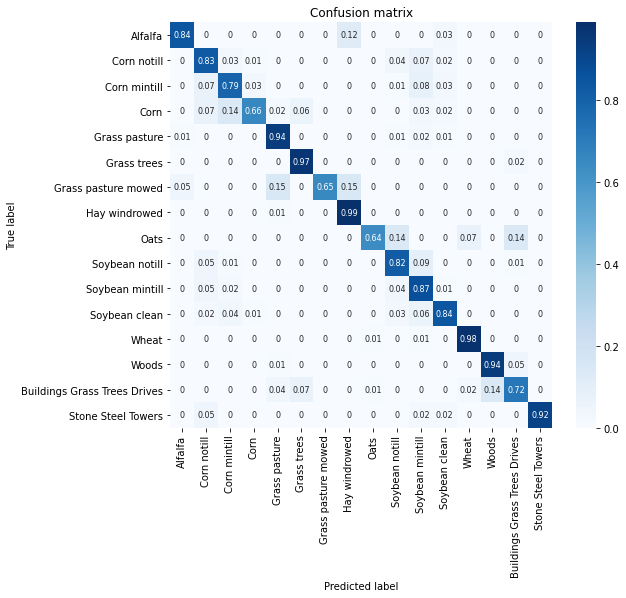

In [ ]:
evaluate_cm(y1_test_wf, y1_pred_wf, LABELS1)

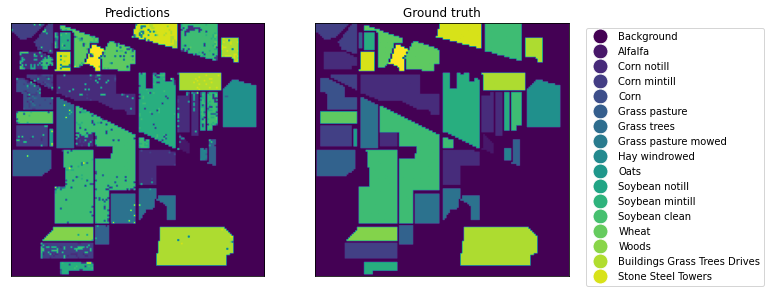

In [ ]:
y1_pred_wf = gs1_wf.predict(X1.reshape((-1, X1.shape[2]))).reshape(y1.shape)

evaluate_pred_image(y1, y1_pred_wf, LABELS1)

Nous pouvons voir ici que la matrice de confusion est majoritairement représentée par sa diagonale ce qui indique qu'aucune classe n'est complètement confondue avec une autre. De plus, nous obtenons des scores relativement corrects (≈ 85%) mais très éloignés de ce que peuvent faire d'autres solutions détaillées dans la littérature scientifique.

In [ ]:
X2_train_wf, X2_test_wf, y2_train_wf, y2_test_wf, test2_idx_wf = get_train_test_sets(X2, y2)

In [ ]:
gs2_wf = GridSearchCV(best_pipeline2, {}, n_jobs=-1, verbose=4)
gs2_wf.fit(X2_train_wf, y2_train_wf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=55)),
                                       ('svc',
                                        SVC(C=980, probability=True,
                                            random_state=1010))]),
             n_jobs=-1, param_grid={}, verbose=4)

In [ ]:
y2_pred_wf = gs2_wf.predict(X2_test_wf)

In [ ]:
evaluate_scores(y2_test_wf, y2_pred_wf, LABELS2)

Overall accuracy (OA): 0.9453681710213777 

Average accuracy (AA): 0.9754934197068561 

Kappa coefficient (KA): 0.9390838777303249 

                           precision    recall  f1-score   support

    Brocoli green weeds 1       1.00      1.00      1.00      1406
    Brocoli green weeds 2       1.00      1.00      1.00      2608
                   Fallow       1.00      1.00      1.00      1383
        Fallow rough plow       1.00      0.99      0.99       976
            Fallow smooth       0.99      0.99      0.99      1875
                  Stubble       1.00      1.00      1.00      2771
                  Celerey       1.00      1.00      1.00      2505
         Grapes untrained       0.85      0.91      0.88      7890
     Soil vinyard develop       1.00      1.00      1.00      4342
Corn senesced green weeds       0.99      0.99      0.99      2295
      Lettuce romaine 4wk       1.00      1.00      1.00       747
      Lettuce romaine 5wk       1.00      1.00      1.00      

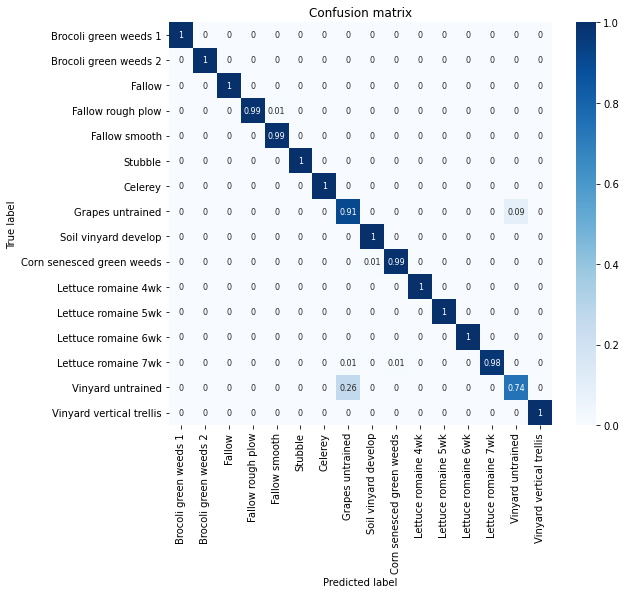

In [ ]:
evaluate_cm(y2_test_wf, y2_pred_wf, LABELS2)

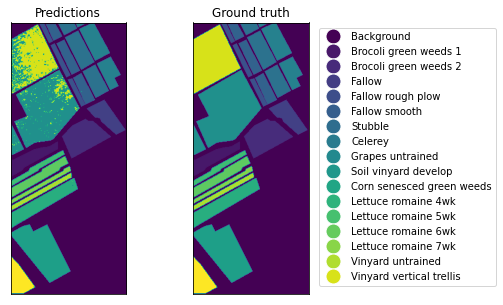

In [ ]:
y2_pred_wf = gs2_wf.predict(X2.reshape((-1, X2.shape[2]))).reshape(y2.shape)

evaluate_pred_image(y2, y2_pred_wf, LABELS2)

Les scores obtenus sur la deuxième image (Salinas) sont bien meilleurs en raison du nombre beaucoup plus important de données dans cette image. On obtient des scores d'environ 95% avec 30% des données utilisées pour l'entraînement; ce qui est un score plutôt satisfaisant pour un problème de classification mais toujours bien inférieur aux solutions existantes.

<a id="section-42"></a>

### 4.2 Sans pré-traitement avec post-traitement

In [ ]:
y1_pred_wf_post = postprocess(gs1_wf, X1, gf1)

HSIProcessing: applied filtering on 16/16 bands.
HSIProcessing: elapsed time 0.028984s.


In [ ]:
y1_test_pred_wf_post = y1_pred_wf_post.flat[test1_idx_wf]

In [ ]:
evaluate_scores(y1_test, y1_test_pred_wf_post, LABELS1)

Overall accuracy (OA): 0.9694773519163763 

Average accuracy (AA): 0.8509530460390007 

Kappa coefficient (KA): 0.9651092512925947 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.97      0.98        32
                 Corn notill       1.00      0.93      0.96      1000
                Corn mintill       0.98      0.99      0.99       581
                        Corn       0.97      0.98      0.97       166
               Grass pasture       0.93      0.98      0.95       338
                 Grass trees       0.99      1.00      0.99       511
         Grass pasture mowed       0.00      0.00      0.00        20
               Hay windrowed       1.00      1.00      1.00       335
                        Oats       0.00      0.00      0.00        14
              Soybean notill       0.98      0.92      0.95       680
             Soybean mintill       0.94      1.00      0.97      1719
               Soybean cle

c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

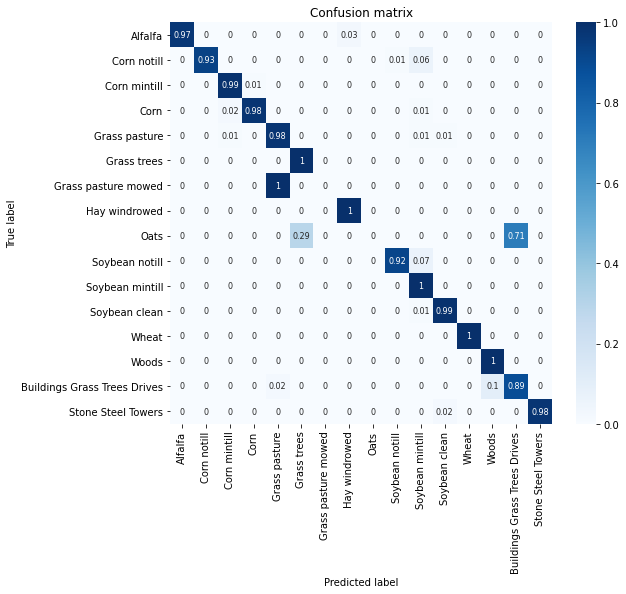

In [ ]:
evaluate_cm(y1_test, y1_test_pred_wf_post, LABELS1)

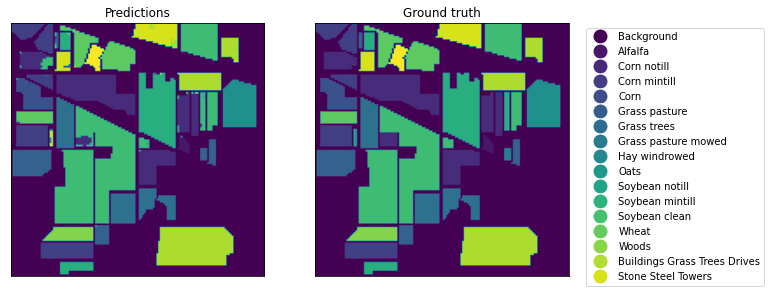

In [ ]:
evaluate_pred_image(y1, y1_pred_wf_post, LABELS1)

Avec le post-traitement rajouté à la méthode simple, à savoir l'utilisation d'un SVM, nous obtenons de bien meilleurs scores. Cependant, nous pouvons voir que la précision moyenne est bien inférieure à la précision globale et au coefficient Kappa. De plus, nous pouvons observer sur la matrice de confusion que deux classes (Grass Pasture Mowed et Oats) sont complètement confondues avec d'autres classes. Ces deux observations résultent du fait que le post-traitement lisse de manière forte les prédictions et vient donc effacer les classes minoritaires.

In [ ]:
y2_pred_wf_post = postprocess(gs2_wf, X2, gf2)

HSIProcessing: applied filtering on 16/16 bands.
HSIProcessing: elapsed time 0.123986s.


In [ ]:
y2_test_pred_wf_post = y2_pred_wf_post.flat[test2_idx_wf]

In [ ]:
evaluate_scores(y2_test, y2_test_pred_wf_post, LABELS2)

Overall accuracy (OA): 0.96215360253365 

Average accuracy (AA): 0.9833097354900747 

Kappa coefficient (KA): 0.9577973893192587 

                           precision    recall  f1-score   support

    Brocoli green weeds 1       1.00      1.00      1.00      1406
    Brocoli green weeds 2       1.00      1.00      1.00      2608
                   Fallow       1.00      1.00      1.00      1383
        Fallow rough plow       1.00      1.00      1.00       976
            Fallow smooth       1.00      1.00      1.00      1875
                  Stubble       1.00      1.00      1.00      2771
                  Celerey       1.00      1.00      1.00      2505
         Grapes untrained       0.88      0.95      0.91      7890
     Soil vinyard develop       1.00      1.00      1.00      4342
Corn senesced green weeds       1.00      1.00      1.00      2295
      Lettuce romaine 4wk       1.00      1.00      1.00       747
      Lettuce romaine 5wk       1.00      1.00      1.00      13

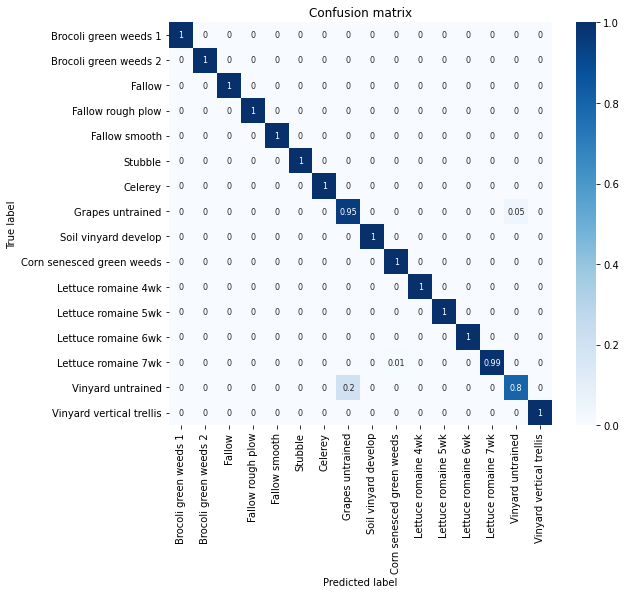

In [ ]:
evaluate_cm(y2_test, y2_test_pred_wf_post, LABELS2)

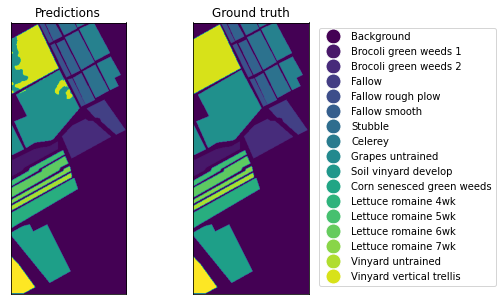

In [ ]:
evaluate_pred_image(y2, y2_pred_wf_post, LABELS2)

Grâce au post-traitement appliqué à la fin de la prédiction de l'image Salinas, nous obtenons de meilleurs scores qui se rapprochent des scores obtenues avec les solutions existantes dans la littérature scientifique (> 95%).

<a id="section-43"></a>

### 4.3 Avec pré-traitement sans post-traitement

In [ ]:
y1_pred = gs1.predict(X1_test)

In [ ]:
evaluate_scores(y1_test, y1_pred, LABELS1)

Overall accuracy (OA): 0.9857839721254356 

Average accuracy (AA): 0.9683514805648283 

Kappa coefficient (KA): 0.983785754753675 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.97      0.98        32
                 Corn notill       0.99      0.98      0.98      1000
                Corn mintill       0.98      0.99      0.98       581
                        Corn       0.97      0.95      0.96       166
               Grass pasture       0.97      0.98      0.98       338
                 Grass trees       0.99      1.00      1.00       511
         Grass pasture mowed       1.00      0.75      0.86        20
               Hay windrowed       1.00      1.00      1.00       335
                        Oats       1.00      1.00      1.00        14
              Soybean notill       0.98      0.97      0.98       680
             Soybean mintill       0.98      0.99      0.99      1719
               Soybean clea

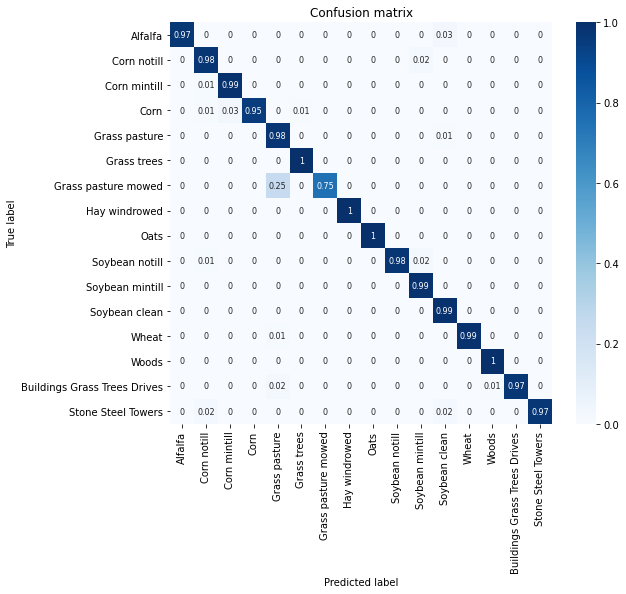

In [ ]:
evaluate_cm(y1_test, y1_pred, LABELS1)

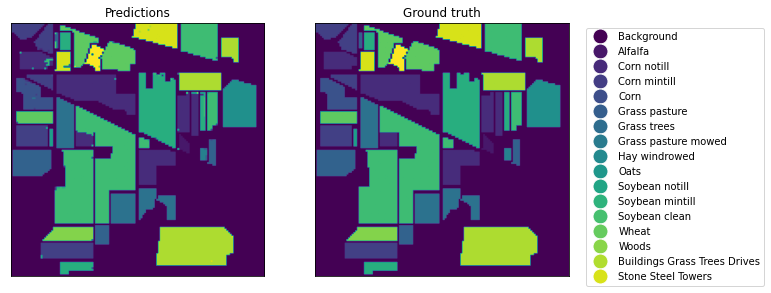

In [ ]:
y1_pred = gs1.predict(X1_f.reshape((-1, X1_f.shape[2]))).reshape(y1.shape)

evaluate_pred_image(y1, y1_pred, LABELS1)

Sur l'image d'Indian Pines nous atteignons enfin des scores très correctes par rapport aux solutions existantes, grâce à l'étape de pré-traitement de l'image. Nous obtenons des scores supérieurs à 97% avec 30% des données d'entraînement. Comparée à l'étape de post-traitement, nous pouvons voir que cette étape est beaucoup plus importante, celle-ci atteignant de meilleurs résultats globaux (précision globale, coefficient Kappa) mais surtout une précision moyenne qui ne chute pas comme c'est le cas pour le post-traitement.

In [ ]:
y2_pred = gs2.predict(X2_test)

In [ ]:
evaluate_scores(y2_test, y2_pred, LABELS2)

Overall accuracy (OA): 0.9906571654790182 

Average accuracy (AA): 0.9957945828264549 

Kappa coefficient (KA): 0.989600664923672 

                           precision    recall  f1-score   support

    Brocoli green weeds 1       1.00      1.00      1.00      1406
    Brocoli green weeds 2       1.00      1.00      1.00      2608
                   Fallow       1.00      1.00      1.00      1383
        Fallow rough plow       1.00      0.99      0.99       976
            Fallow smooth       0.99      1.00      1.00      1875
                  Stubble       1.00      1.00      1.00      2771
                  Celerey       1.00      1.00      1.00      2505
         Grapes untrained       0.99      0.97      0.98      7890
     Soil vinyard develop       1.00      1.00      1.00      4342
Corn senesced green weeds       1.00      1.00      1.00      2295
      Lettuce romaine 4wk       1.00      1.00      1.00       747
      Lettuce romaine 5wk       1.00      1.00      1.00      1

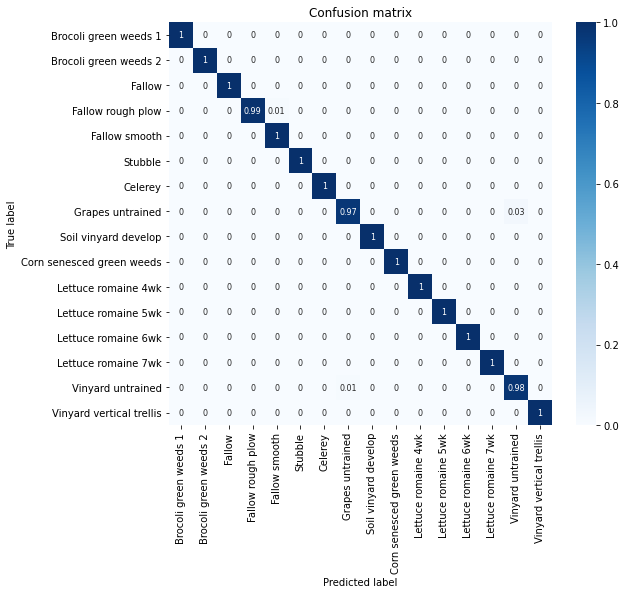

In [ ]:
evaluate_cm(y2_test, y2_pred, LABELS2)

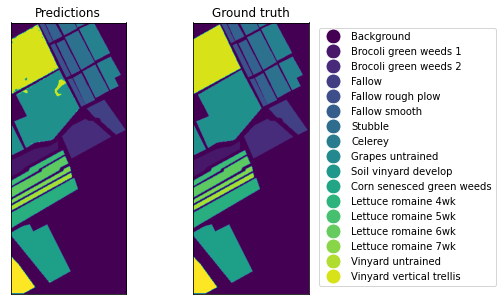

In [ ]:
y2_pred = gs2.predict(X2_f.reshape((-1, X2_f.shape[2]))).reshape(y2.shape)

evaluate_pred_image(y2, y2_pred, LABELS2)

Grâce au pré-traitement, nous atteignons des scores très bons pour l'image Salinas (> 99%).

<a id="section-44"></a>

### 4.4 Avec pré-traitement et post-traitement

In [ ]:
y1_test_pred_f = y1_pred_f.flat[test1_idx]

In [ ]:
evaluate_scores(y1_test, y1_test_pred_f, LABELS1)

Overall accuracy (OA): 0.9863414634146341 

Average accuracy (AA): 0.9019173038898066 

Kappa coefficient (KA): 0.9844124496632854 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        32
                 Corn notill       0.98      0.98      0.98      1000
                Corn mintill       0.99      0.99      0.99       581
                        Corn       1.00      0.98      0.99       166
               Grass pasture       0.94      0.99      0.96       338
                 Grass trees       0.99      1.00      0.99       511
         Grass pasture mowed       0.00      0.00      0.00        20
               Hay windrowed       1.00      1.00      1.00       335
                        Oats       1.00      0.57      0.73        14
              Soybean notill       0.99      0.95      0.97       680
             Soybean mintill       0.98      1.00      0.99      1719
               Soybean cle

c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

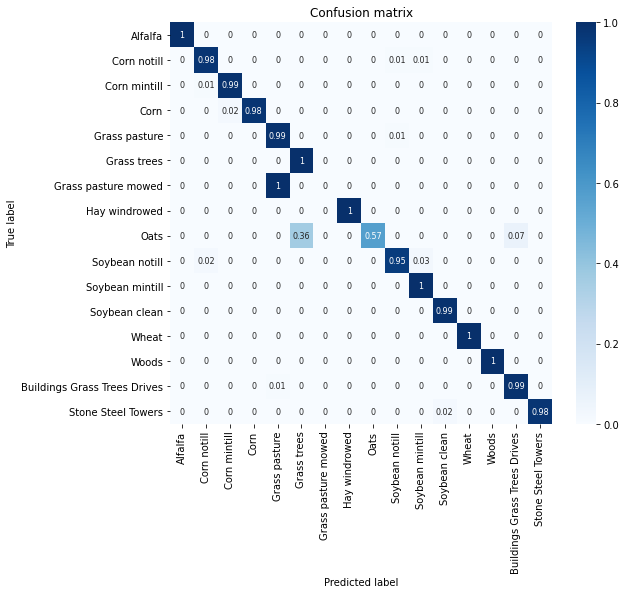

In [ ]:
evaluate_cm(y1_test, y1_test_pred_f, LABELS1)

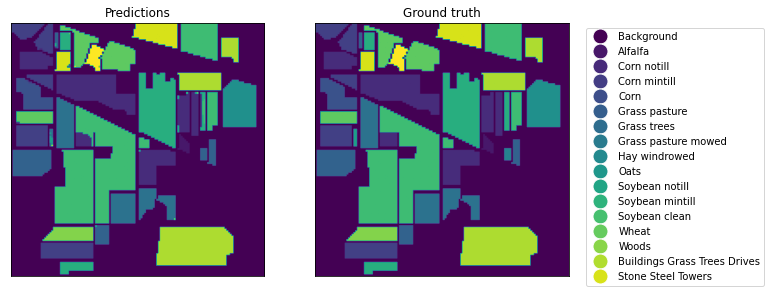

In [ ]:
evaluate_pred_image(y1, y1_pred_f, LABELS1)

La combinaison entre le pré-traitement et le post-traitement est discutable et dépend du besoin métier de la start-up Carrotte 4.0. En effet, la précision globale et le coefficient Kappa ont été légèrement augmentés par rapport à la méthode avec seulement le pré-traitement. Cependant, la précision moyenne a considérablement chuté en raison du post-traitement et de ses limitations.

In [ ]:
y2_test_pred_f = y2_pred_f.flat[test2_idx]

In [ ]:
evaluate_scores(y2_test, y2_test_pred_f, LABELS2)

Overall accuracy (OA): 0.9956188968065453 

Average accuracy (AA): 0.9977257249001164 

Kappa coefficient (KA): 0.9951227570976413 

                           precision    recall  f1-score   support

    Brocoli green weeds 1       1.00      1.00      1.00      1406
    Brocoli green weeds 2       1.00      1.00      1.00      2608
                   Fallow       1.00      1.00      1.00      1383
        Fallow rough plow       1.00      0.99      0.99       976
            Fallow smooth       0.99      1.00      1.00      1875
                  Stubble       1.00      1.00      1.00      2771
                  Celerey       1.00      1.00      1.00      2505
         Grapes untrained       1.00      0.98      0.99      7890
     Soil vinyard develop       1.00      1.00      1.00      4342
Corn senesced green weeds       1.00      1.00      1.00      2295
      Lettuce romaine 4wk       1.00      1.00      1.00       747
      Lettuce romaine 5wk       1.00      1.00      1.00      

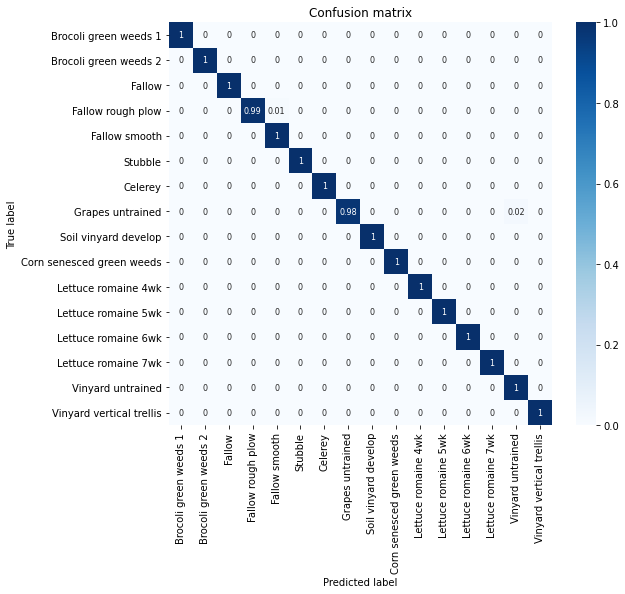

In [ ]:
evaluate_cm(y2_test, y2_test_pred_f, LABELS2)

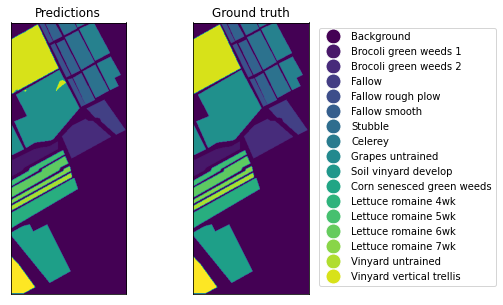

In [ ]:
evaluate_pred_image(y2, y2_pred_f, LABELS2)

La combinaison entre le pré-traitement et le post-traitement est une vraie réussite pour l'image Salinas qui a vu tous ses scores de test augmentés. Nous atteignons des scores supérieurs à 99.5% grâce à cette méthode.

Pour la solution finale, nous avons quand même préférer garder la combinaison entre le pré-traitement et le post-traitement. En effet, si nous sommes dans la perspective d'avoir plus de données fournies par la suite, nous pourrons alors tirer parti au maximum des bénéfices de cette combinaison puisque nous nous rapprocherons plus du cas de Salinas que du cas d'Indian Pines. Dans le cas où les classes sont plus fournies, l'impact négatif du post-traitement est alors converti en impact positif comme sur Salinas.

<a id="section-45"></a>

### 4.5 En faisant varier le pourcentage de données d'entraînement

In [ ]:
def evaluation_over_test_ratio(X_f, gf, y, pipeline, grid_params):
  oa_over_test_ratio = []
  aa_over_test_ratio = []
  ka_over_test_ratio = []

  x = np.arange(0.1, 1, 0.1)

  for test_ratio in x:
    X_train, X_test, y_train, y_test, test_idx = get_train_test_sets(X_f, y, test_ratio=test_ratio)

    gs = GridSearchCV(pipeline, grid_params, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)

    y_pred_f = postprocess(gs, X_f, gf, verbose=False)
    y_test_pred_f = y_pred_f.flat[test_idx]

    oa_over_test_ratio.append(accuracy_score(y_test, y_test_pred_f))
    aa_over_test_ratio.append(balanced_accuracy_score(y_test, y_test_pred_f))
    ka_over_test_ratio.append(cohen_kappa_score(y_test, y_test_pred_f))

  plt.title('Evaluation over test ratio')
  plt.xlabel('Test ratio')
  plt.ylabel('Accuracy')

  plt.plot(x, oa_over_test_ratio, label='OA')
  plt.plot(x, aa_over_test_ratio, label='AA')
  plt.plot(x, ka_over_test_ratio, label='KA')

  plt.legend(loc='lower left')

  plt.show()

c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\theol\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


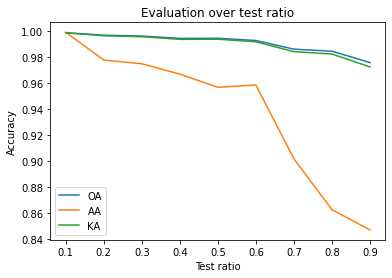

In [ ]:
evaluation_over_test_ratio(X1_f, gf1, y1, best_pipeline, {})

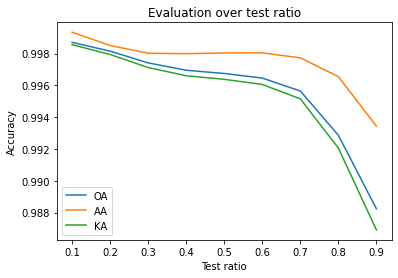

In [ ]:
evaluation_over_test_ratio(X2_f, gf2, y2, best_pipeline2, {})

<a id="section-5"></a>

## 5. Conclusion et analyse des résultats

Dans l'ensemble les résultats sont **très satisfaisants**. On obtient $98.63\%$ d'overall accuracy sur l'image d'Indian Pines et $99.56\%$ pour l'image de Salinas.

Ces résultats sont obtenus en utilisant 30% des données pour l'entrainement. En utilisant **peu de données** pour l'entrainement, on s'assure de la capacité (tout-de-même restreinte) de **généralisation** du classifieur.  

Il est intéressant d'observer l'évolution de cette précision selon le pourcentage de données utilisé dans pour le test set. On constate que pour l'image d'Indian Pines, l'overall score reste supérieur à $98\%$ même pour des portions très petites prises dans le train set. On remarque cependant que l'average score (en prenant en compte la taille des classes) chute au-delà de $60\%$ utilisé pour le test set. Ce score reste cependant très bon avec une précision supérieure à $85\ %$. Pour l'image Salinas, les scores restent tous très hauts ($> 98\%$) peu importe le ratio pris.  

Ces résultats sont donc assez encourageants quant à la capacité de généralisation de notre classifieur. Il faut cependant **nuancer** ces résultats. Pour être certains de sa capacité de généralisation, il aurait fallu mesurer les performances de notre classifieur sur des images **hyperspectrales jamais vues**.

Autre constat intéressant, le post-processing améliore l'overall score mais diminue l'average score. En effet, les résultats de prédiction sont lissés et donc globalement meilleurs mais ce filtre a tendance à "effacer" certaines classes très peu présentes et donc à diminuer l'average score qui prend lui en compte la densité de chaque classe. Cela depend donc de l'application métier : si les classes peu présentes sont de grande importance ou si c'est le résultat global qui est important.

La fonction `predict_image` que nous proposons à Carotte 4.0 est présentée ci-dessous.

In [ ]:
def predict_image(image, model):
    start = time.time()

    gf = HSIProcessing(image, r=3)
    image_f = gf.apply(image, verbose=False)
    preds = postprocess(model, image_f, gf, verbose=False)
    
    end = time.time()
    print('Prediction time: {}s'.format(str(round(end - start, 2))))
    return preds

Prediction time: 2.85s


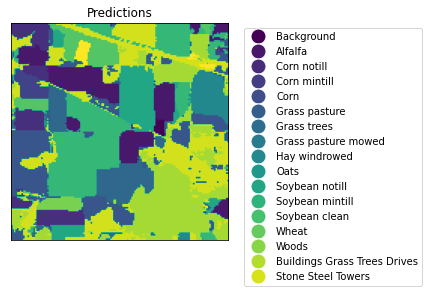

In [ ]:
preds1 = predict_image(X1, gs1)

# Plot preds
plt.title('Predictions')
plt.imshow(preds1)
plt.xticks([])
plt.yticks([])
gt_add_legend(LABELS1)
plt.show()

Prediction time: 24.19s


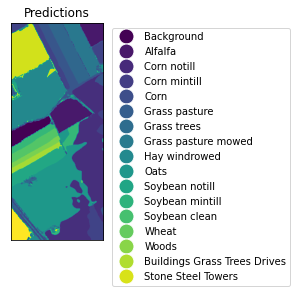

In [ ]:
preds2 = predict_image(X2, gs2)

# Plot preds
plt.title('Predictions')
plt.imshow(preds2)
plt.xticks([])
plt.yticks([])
gt_add_legend(LABELS1)
plt.show()

<a id="section-6"></a>

## 6. Travail individuel

- Nicolas Blin
    1. Première approche : tester les différents classifieurs (SVM, RandomForest, KNeighborsClassifier). Lancer un GridSearch exhaustif pour tester toutes les combinaisons d'hyperparamètres / valeurs de PCA sur les 2 images pour trouver la meilleure combinaison.
    2. Préparation de la soutenance, création des slides.
    3. Écriture du texte/explications du notebook.

---

- Théo Lepage
    1. Implémentation de l'article scientifique (en particulier le filtre guidé).
    2. Organisation du notebook/rapport.
    3. Entraînement avec la nouvelle approche basée sur les filtres guidés.
    4. Chargement, préparation et séparation des données.

---

- Quentin Kaci
    1. Trouver et implémenter l'article scientifique.
    2. Choix des méthodes d'évalution des résultats et affichage des scores.
    3. Adaptation des slides.
    4. Ecriture du texte pour les explications du notebook.